In [1]:
import locale
from pathlib import Path
from typing import Sequence

import matplotlib.axes._axes as axes
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Figure



In [2]:
PATH = Path(r"C:\Users\balco\Downloads\phd_data")
# 81 Days of data
DAY_INDEX = [1, 11, 23, 35, 45, 54, 70, 75] #  by day
DAY_INDEX_MEAN = [1, 11, 23, 35, 45, 54, 70, 75] # by day and mean
FOLDER_INDEX = [5] 

CB91_Blue = "#2CBDFE"
CB91_Green = "#47DBCD"
CB91_Pink = "#F3A0F2"
CB91_Purple = "#9D2EC5"
CB91_Violet = "#661D98"
CB91_Amber = "#F5B14C"

color_list = [
    CB91_Blue,
    CB91_Amber,
    CB91_Green,
    CB91_Violet,
    CB91_Pink,
    CB91_Purple,
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_list)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

locale.setlocale(locale.LC_ALL, 'es-MX')
LOCATOR = mdates.AutoDateLocator(minticks=3, maxticks=5)
FORMATTER = mdates.ConciseDateFormatter(LOCATOR)


In [3]:
def mean_across_dataframes(dfs: Sequence[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(dfs).groupby(level=0).mean()


def read_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True)

    return df


def get_dirs(name: str):
    """Get all directories which contain the specified word in their name"""
    return PATH.glob(f"*{name}*")


def get_file_from_dir(dir_: Path, index: int):
    """Get the csv at the specified position"""
    return list(dir_.glob("*.csv"))[index]


def get_files(name: str, index: int):
    """
    Get the csv files at the specified position for all the directories which contain the word `name`
    """
    return (get_file_from_dir(d, index) for d in get_dirs(name))


def combine_df(
    dfs: Sequence[pd.DataFrame], names: Sequence[str], feature: str = "Power", feat_opt: str = "Optimum Power"
) -> pd.DataFrame:
    """
    Combine multiple dataframes into a single one
    """

    combined_df = {}

    if feat_opt:
        combined_df[names[-1]] = dfs[0][feat_opt]

    for df, name in zip(dfs, names):
        combined_df[name] = df[feature]

    return pd.DataFrame(combined_df)


def plot_combined(df: pd.DataFrame, ylabel: str = "", multiplier: int = 1, locator=None, formatter=None, effs=None) -> Figure:
    locator = locator or LOCATOR
    formatter = formatter or FORMATTER

    fig = plt.figure()
    ax: axes.Axes = fig.add_subplot(111)

    effs = effs or compute_eff(df)

    for column, eff in zip(df.columns, effs):
        if 'Óptimo' in column:
            continue
        else:
            label = f'{column} ({eff:.1f}\%)'
        ax.plot(df.index, df[column] * multiplier, label=label)

    if 'Óptimo' in df.columns:
        ax.plot(df.index, df['Óptimo'] * multiplier, 'k--', label='Óptimo')

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc="lower right")

    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.1, 1.1)

    return fig


def compute_eff(df: pd.DataFrame) -> pd.DataFrame:
    sum_ = df.sum()
    max_ = sum_[0]

    effs = [s * 100 / max_ for s in sum_]

    return effs


def add_day_offset(df: pd.DataFrame, days: int) -> pd.DataFrame:
    df.index = df.index + pd.DateOffset(days=days)
    return df

def subtract_day_offset(df: pd.DataFrame, days: int) -> pd.DataFrame:
    df.index = df.index - pd.DateOffset(days=days)
    return df

In [4]:
def main_plot_train_day():
    for i, day in enumerate(DAY_INDEX):
        for j, folder in enumerate(FOLDER_INDEX):
            if day > 15:
                po_train_files = [list(get_files("po_train", day + 10))[0]]
                ddpg_train_files = [list(get_files("ddpg_train", day + 10))[folder]]
                td3_train_files = [list(get_files("td3_train", day + 10))[folder]]
                td4_train_files = [list(get_files("td3exp_train", day))[folder]]

                assert len(po_train_files) == 1
                assert len(ddpg_train_files) == 1
                assert len(td3_train_files) == 1
                assert len(td4_train_files) == 1

                po_mean = mean_across_dataframes(read_csv(f) for f in po_train_files)
                ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_train_files))
                td3_mean = mean_across_dataframes((read_csv(f) for f in td3_train_files))
                td4_mean = mean_across_dataframes((read_csv(f) for f in td4_train_files))

                po_mean = add_day_offset(po_mean, days=-10)
                ddpg_mean = add_day_offset(ddpg_mean, days=-10)
                td3_mean = add_day_offset(td3_mean, days=-10)

                po_eff = po_mean['Efficiency'].mean() * 100
                ddpg_eff = ddpg_mean['Efficiency'].mean() * 100
                td3_eff = td3_mean['Efficiency'].mean() * 100
                td4_eff = td4_mean['Efficiency'].mean() * 100
                effs = [0, po_eff, ddpg_eff, td3_eff, td4_eff]

                df = combine_df(
                    [po_mean, ddpg_mean, td3_mean, td4_mean],
                    ["P\&O","DDPG", "TD3", "TD4", 'Óptimo'],
                    feature="Duty Cycle", feat_opt='Optimum Duty Cycle'
                )
            else:
                po_train_files = [list(get_files("po_train", day))[0]]
                ddpg_train_files = [list(get_files("ddpg_train", day))[folder]]
                td3_train_files = [list(get_files("td3_train", day))[folder]]
                td4_train_files = [list(get_files("td3exp_train", day))[folder]]

                assert len(po_train_files) == 1
                assert len(ddpg_train_files) == 1
                assert len(td3_train_files) == 1
                assert len(td4_train_files) == 1

                po_mean = mean_across_dataframes(read_csv(f) for f in po_train_files)
                ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_train_files))
                td3_mean = mean_across_dataframes((read_csv(f) for f in td3_train_files))
                td4_mean = mean_across_dataframes((read_csv(f) for f in td4_train_files))
                td4_mean_plot = (ddpg_mean + td3_mean) / 2
                td4_mean_plot['Power'] = td4_mean_plot['Power'].clip(0, td4_mean_plot['Optimum Power'])
                filter_ = td4_mean_plot['Power'] == td4_mean_plot['Optimum Power']
                td4_mean_plot['Duty Cycle'][filter_] = td4_mean_plot['Optimum Duty Cycle'][filter_]

                po_eff = po_mean['Efficiency'].mean() * 100
                ddpg_eff = ddpg_mean['Efficiency'].mean() * 100
                td3_eff = td3_mean['Efficiency'].mean() * 100
                td4_eff = td4_mean_plot['Efficiency'].mean() * 100
                effs = [0, po_eff, ddpg_eff, td3_eff, td4_eff]

                df = combine_df(
                    [po_mean, ddpg_mean, td3_mean, td4_mean_plot],
                    ["P\&O","DDPG", "TD3", "TD4", 'Óptimo'],
                    feature="Duty Cycle", feat_opt='Optimum Duty Cycle'
                )

            p = plot_combined(df, ylabel="Ciclo de trabajo", effs=effs)

            p.savefig(f"output\\fig_19_mppt_comparison_train_duty_cycle_day_{j:04}_{i:02}.pdf", bbox_inches="tight")

            # plt.close(p)

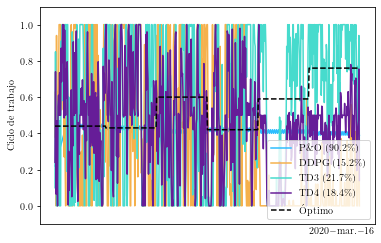

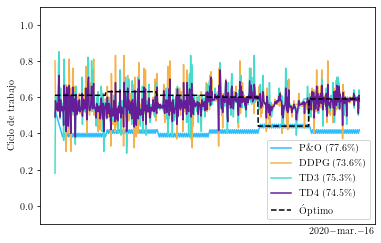

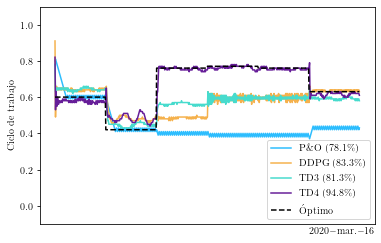

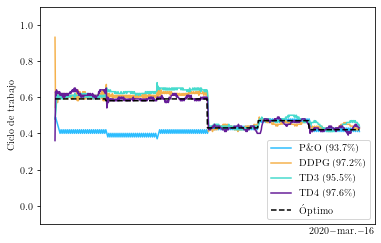

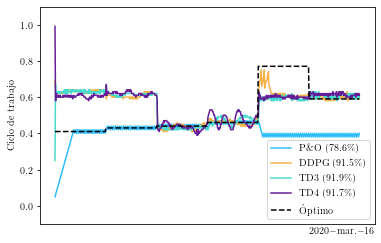

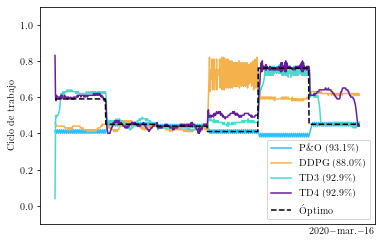

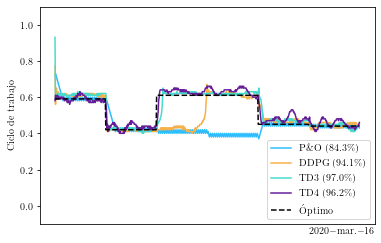

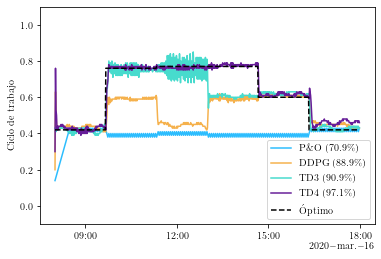

In [5]:
main_plot_train_day()

In [6]:
def main_plot_train_mean():
    for i, day in enumerate(DAY_INDEX_MEAN):
        if day > 15:
            po_train_files = [list(get_files("po_train", day + 10))[0]]
            ddpg_train_files = list(get_files("ddpg_train", day + 10))
            td3_train_files = list(get_files("td3_train", day + 10))
            td4_train_files = list(get_files("td3exp_train", day))

            assert len(po_train_files) == 1
            assert len(ddpg_train_files) == 110
            assert len(td3_train_files) == 110
            assert len(td4_train_files) == 110

            po_mean = mean_across_dataframes(read_csv(f) for f in po_train_files)
            ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_train_files))
            td3_mean = mean_across_dataframes((read_csv(f) for f in td3_train_files))
            td4_mean = mean_across_dataframes((read_csv(f) for f in td4_train_files))

            po_mean = add_day_offset(po_mean, days=-10)
            ddpg_mean = add_day_offset(ddpg_mean, days=-10)
            td3_mean = add_day_offset(td3_mean, days=-10)

            po_eff = po_mean['Efficiency'].mean() * 100
            ddpg_eff = ddpg_mean['Efficiency'].mean() * 100
            td3_eff = td3_mean['Efficiency'].mean() * 100
            td4_eff = td4_mean['Efficiency'].mean() * 100
            effs = [0, po_eff, ddpg_eff, td3_eff, td4_eff]

            df = combine_df(
                [po_mean, ddpg_mean, td3_mean, td4_mean],
                ["P\&O","DDPG", "TD3", "TD4", 'Óptimo'],
                feature="Duty Cycle", feat_opt='Optimum Duty Cycle'
            )
        else:
            po_train_files = [list(get_files("po_train", day))[0]]
            ddpg_train_files = list(get_files("ddpg_train", day))
            td3_train_files = list(get_files("td3_train", day))
            td4_train_files = list(get_files("td3exp_train", day))

            assert len(po_train_files) == 1
            assert len(ddpg_train_files) == 110
            assert len(td3_train_files) == 110
            assert len(td4_train_files) == 110

            po_mean = mean_across_dataframes(read_csv(f) for f in po_train_files)
            ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_train_files))

            td3_mean = mean_across_dataframes((read_csv(f) for f in td3_train_files))
            td4_mean = mean_across_dataframes((read_csv(f) for f in td4_train_files))
            td4_mean_plot = (ddpg_mean + td3_mean) / 2
            td4_mean_plot['Power'] = td4_mean_plot['Power'].clip(0, td4_mean_plot['Optimum Power'])
            filter_ = td4_mean_plot['Power'] == td4_mean_plot['Optimum Power']
            td4_mean_plot['Duty Cycle'][filter_] = td4_mean_plot['Optimum Duty Cycle'][filter_]

            po_eff = po_mean['Efficiency'].mean() * 100
            ddpg_eff = ddpg_mean['Efficiency'].mean() * 100
            td3_eff = td3_mean['Efficiency'].mean() * 100
            td4_eff = td4_mean_plot['Efficiency'].mean() * 100
            effs = [0, po_eff, ddpg_eff, td3_eff, td4_eff]

            df = combine_df(
                [po_mean, ddpg_mean, td3_mean, td4_mean_plot],
                ["P\&O","DDPG", "TD3", "TD4", 'Óptimo'],
                feature="Duty Cycle", feat_opt='Optimum Duty Cycle'
            )

        p = plot_combined(df, ylabel="Ciclo de trabajo", effs=effs)

        p.savefig(f"output\\fig_19_mppt_comparison_train_duty_cycle_mean_{i:02}.pdf", bbox_inches="tight")

        # plt.close(p)


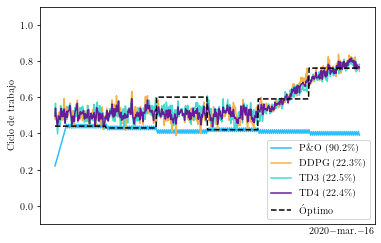

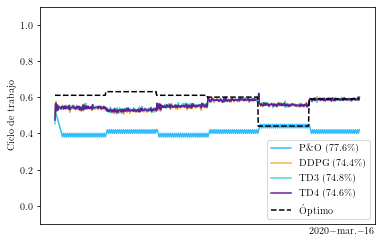

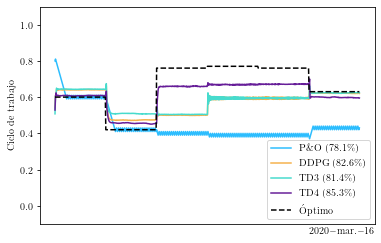

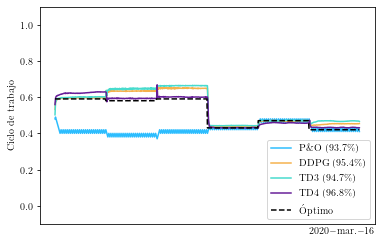

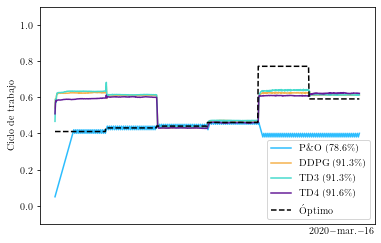

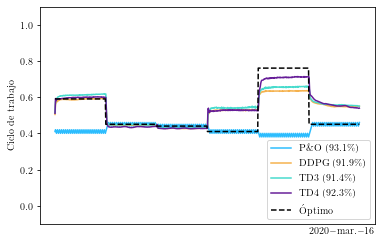

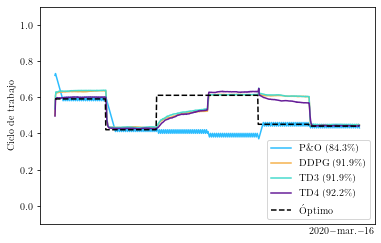

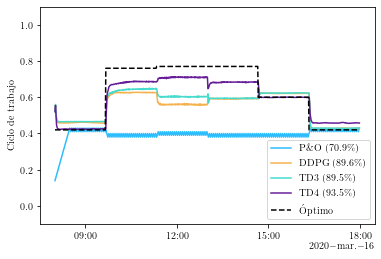

In [7]:
main_plot_train_mean()